# Make Pretty Plots

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import CombineCCFs
import numpy as np
from astropy import units as u, constants
from HelperFunctions import fwhm, Gauss, integral
import os
import lmfit

from scipy.interpolate import InterpolatedUnivariateSpline as spline

sns.set_context('poster', font_scale=1.5)

home = os.environ['HOME']


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Get and shift the Cross-correlation functions to the primary star rest frame

Run with T > 6000 first, to measure the primary star radial velocity in my CCFs. Then, run with T = 4000 or so to detect the companion.

In [3]:
hdf_file = '{}/School/Research/McDonaldData/PlanetData/PsiDraA/Cross_correlations/CCF.hdf5'.format(home)
output_dir = '{}/School/Research/McDonaldData/PlanetData/Paper/Figures/'.format(home)

T = 4000
vsini = 1
logg = 4.5
metal = 0.0
dV = 0.01
#dV = 0.1
c = constants.c.cgs.to(u.m/u.s).value
xgrid = np.arange(-400, 400+dV/2., dV)
ccfs, original_files = CombineCCFs.get_ccfs(T=T, vsini=vsini, logg=logg, metal=metal,
                                        hdf_file=hdf_file, xgrid=xgrid)

(-12.924013515021281, 'RV31378-1_telluric_corrected.fits')
(-13.143010403423075, 'RV31380-1_telluric_corrected.fits')
(-12.003705650106246, 'RV33985-1_telluric_corrected.fits')
(-14.048953684277098, 'RV40657-1_telluric_corrected.fits')
(-13.883806121470315, 'RV41804-1_telluric_corrected.fits')
(-13.915250060662759, 'RV41806-1_telluric_corrected.fits')
(-13.646638138326763, 'RV42158-1_telluric_corrected.fits')
(-13.428089365176973, 'RV42333-1_telluric_corrected.fits')
(-12.535378347673428, 'RV42460-1_telluric_corrected.fits')
(-13.655731306157508, 'RV43838-1_telluric_corrected.fits')
(-12.34735445174174, 'RV44144-1_telluric_corrected.fits')
(-13.249374536972795, 'RV44764-1_telluric_corrected.fits')
(-13.105458495080921, 'RV46786-1_telluric_corrected.fits')
(-13.020718108076688, 'RV46787-1_telluric_corrected.fits')
(-13.317769722370675, 'RV46903-1_telluric_corrected.fits')
(-14.39609472414916, 'RV47237-1_telluric_corrected.fits')
(-13.092534833831255, 'RV47671-1_telluric_corrected.fits')

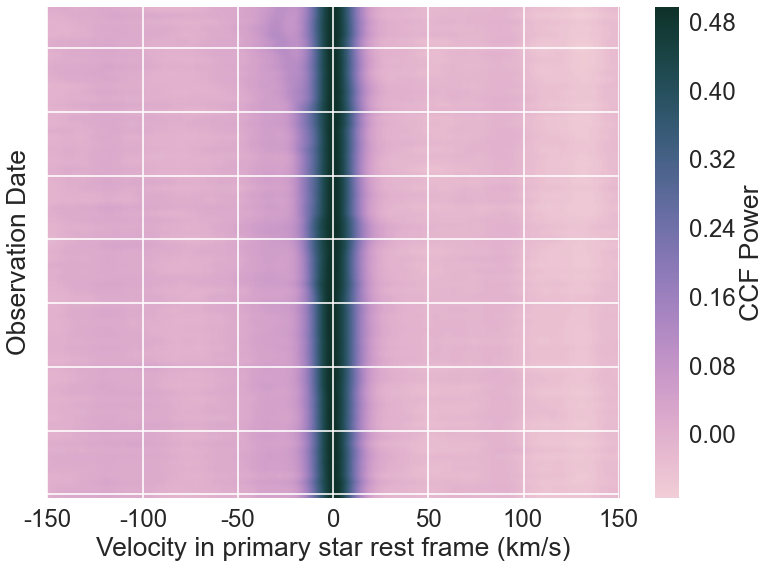

In [4]:
# Plot all the CCFs
cmap = sns.cubehelix_palette(reverse=False, as_cmap=True, gamma=1, rot=0.7, start=2)
fig, ax = plt.subplots(1, 1)
out = ax.imshow(ccfs, cmap=cmap, aspect='auto', origin='lower')#, vmin=vmin, vmax=vmax)
min_v = -150.
max_v = 150.
dv_ticks = 50.0/dV
ax.set_xlim(((min_v+400)/dV, (max_v+400)/dV))
ticks = np.arange((min_v+400)/dV, (max_v+400)/dV+1, dv_ticks)
ax.set_xticks((ticks))
ax.set_xticklabels((-150, -100, -50, 0, 50, 100, 150))
ax.set_xlabel('Velocity in primary star rest frame (km/s)')
ax.set_yticklabels(())
ax.set_ylabel('Observation Date')

# Colorbar
cb = plt.colorbar(out)
cb.set_label('CCF Power')

# Save
plt.savefig('{}Original_CCFs.pdf'.format(output_dir))

In [5]:
avg_ccf = np.mean(ccfs, axis=0)

In [6]:
normed_ccfs = ccfs - avg_ccf

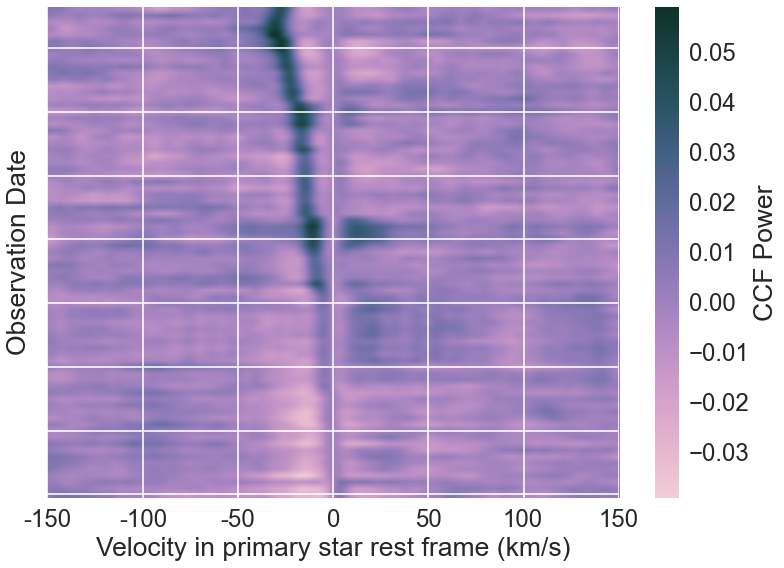

In [7]:
# Set up the scaling manually
low, high = np.min(normed_ccfs), np.max(normed_ccfs)
rng = max(abs(low), abs(high))
vmin = np.sign(low) * rng
vmax = np.sign(high) * rng

# Make the actual plot
#cmap = sns.cubehelix_palette(reverse=False, as_cmap=True, gamma=1, rot=0.7, start=2) #defined above now...
fig, ax = plt.subplots(1, 1)
out = ax.imshow(normed_ccfs, cmap=cmap, aspect='auto', origin='lower')#, vmin=vmin, vmax=vmax)
ax.set_xlim(((min_v+400)/dV, (max_v+400)/dV))
ticks = np.arange((min_v+400)/dV, (max_v+400)/dV+1, dv_ticks)
ax.set_xticks((ticks))
ax.set_xticklabels((-150, -100, -50, 0, 50, 100, 150))
ax.set_xlabel('Velocity in primary star rest frame (km/s)')
ax.set_yticklabels(())
ax.set_ylabel('Observation Date')

# Colorbar
cb = plt.colorbar(out)
cb.set_label('CCF Power')

plt.savefig('{}Resid_CCFs.pdf'.format(output_dir))

# Measure the mass-ratio (q)
To measure the mass-ratio, we first need to subtract a reference velocity from each of the differential velocity measurements. The referene velocity is a combination of the barycentric velocity of the template spectrum and any systematic velocity difference between my model spectra and the true absolute RV.

In [ ]:
# Now, check various values of the mass-ratio q (mass ratio)
drv = np.array([CombineCCFs.get_prim_rv(f) for f in original_files])
qvals = np.arange(0.18, 0.35, 0.001)
V0_vals = np.arange(-10, 0, 0.3)
snr = np.zeros(qvals.size * V0_vals.size)
snr_err = np.zeros(qvals.size * V0_vals.size)
height = np.zeros(qvals.size * V0_vals.size)
height_err = np.zeros(qvals.size * V0_vals.size)
stacked_ccfs = []
peak_velocity = np.zeros(qvals.size * V0_vals.size)
peak_velocity_err = np.zeros(qvals.size * V0_vals.size)
peak_width = np.zeros(qvals.size * V0_vals.size)
peak_width_err = np.zeros(qvals.size * V0_vals.size)
reference_velocity = np.zeros(qvals.size * V0_vals.size)
f = 1.0   # Scale all error bars by this much

# Set up the lmfit model
def line(x, slope, intercept):
    return slope * x + intercept

def constant(x, constant):
    return x + constant

mod = lmfit.Model(line) + lmfit.Model(Gauss)
N=int(10/dV) # Number of indices to the left and right of the maximum to fit

for k, V0 in enumerate(V0_vals):
    prim_vel = drv + V0
    for j, q in enumerate(qvals):
        print(V0, q)
        total_ccf = np.zeros(normed_ccfs.shape[1])
        minvel = np.inf
        #for i in range(30, normed_ccfs.shape[0]):
        for i in range(normed_ccfs.shape[0]):
            ccf = CombineCCFs.spline(xgrid, normed_ccfs[i])
            vel = prim_vel[i] * (1. - 1./q)
            if vel < minvel:
                minvel = vel
            total_ccf += ccf(xgrid + vel)
        good = np.where(xgrid > xgrid[0] - minvel)[0]

        # Fit the stacked CCF to a gaussian
        vel, corr = xgrid[good], total_ccf[good]/float(normed_ccfs.shape[0])
        maxidx = np.argmax(corr)
        result = mod.fit(corr[maxidx-N:maxidx+N], x=vel[maxidx-N:maxidx+N], 
                         amp=corr[maxidx], mu=vel[maxidx], sigma=4, slope=0, intercept=0)
        amp, mu, sig = result.params['amp'].value, result.params['mu'].value, result.params['sigma'].value
        slope, intercept = result.params['slope'].value, result.params['intercept'].value
        amp_err, mu_err, sig_err = result.params['amp'].stderr, result.params['mu'].stderr, result.params['sigma'].stderr
        slope_err, intercept_err = result.params['slope'].stderr, result.params['intercept'].stderr
        amp_err *= f
        mu_err *= f
        sig_err *= f
        slope_err *= f
        intercept_err *= f
        noise_idx = np.ones(vel.shape, dtype=bool)
        noise_idx[maxidx-N:maxidx+N] = 0
        noise = np.std(corr[noise_idx])
        baseline = np.mean(corr[noise_idx])

        height[j + k*qvals.size] = ((amp + (intercept + slope*mu) - baseline))
        height_err[j + k*qvals.size] = (np.sqrt(amp_err**2 + intercept_err**2 + (mu*slope_err)**2 + (slope*mu_err)**2))
        snr[j + k*qvals.size] = (height[j + k*qvals.size]/noise)
        snr_err[j + k*qvals.size] = (height_err[j + k*qvals.size]/noise)
        peak_velocity[j + k*qvals.size] = (mu)
        peak_velocity_err[j + k*qvals.size] = (mu_err)
        peak_width[j + k*qvals.size] = (sig)
        peak_width_err[j + k*qvals.size] = (sig_err)
        reference_velocity[j + k*qvals.size] = V0

(-10.0, 0.17999999999999999)
(-10.0, 0.18099999999999999)
(-10.0, 0.182)
(-10.0, 0.183)
(-10.0, 0.184)
(-10.0, 0.185)
(-10.0, 0.186)
(-10.0, 0.187)
(-10.0, 0.188)
(-10.0, 0.189)
(-10.0, 0.19)
(-10.0, 0.191)
(-10.0, 0.192)
(-10.0, 0.193)
(-10.0, 0.19400000000000001)
(-10.0, 0.19500000000000001)
(-10.0, 0.19600000000000001)
(-10.0, 0.19700000000000001)
(-10.0, 0.19800000000000001)
(-10.0, 0.19900000000000001)
(-10.0, 0.20000000000000001)
(-10.0, 0.20100000000000001)
(-10.0, 0.20200000000000001)
(-10.0, 0.20300000000000001)
(-10.0, 0.20400000000000001)
(-10.0, 0.20500000000000002)
(-10.0, 0.20600000000000002)
(-10.0, 0.20700000000000002)
(-10.0, 0.20800000000000002)
(-10.0, 0.20900000000000002)
(-10.0, 0.21000000000000002)
(-10.0, 0.21100000000000002)
(-10.0, 0.21200000000000002)
(-10.0, 0.21300000000000002)
(-10.0, 0.21400000000000002)
(-10.0, 0.21500000000000002)
(-10.0, 0.21600000000000003)
(-10.0, 0.21700000000000003)
(-10.0, 0.21800000000000003)
(-10.0, 0.21900000000000003)
(-10.0, 0

## Find the best reference velocity.

In [19]:
summary = pd.DataFrame(data={'V0': reference_velocity, 'height': height, 'height_err': height_err,
                             'snr': snr, 'snr_err': snr_err, 
                             'peak_velocity': peak_velocity, 'peak_velocity_err': peak_velocity_err,
                             'peak_width': peak_width, 'peak_width_err': peak_width_err,
                             'q': np.hstack([qvals]*V0_vals.size)})

Best Reference Velocity = -2.08 km/s


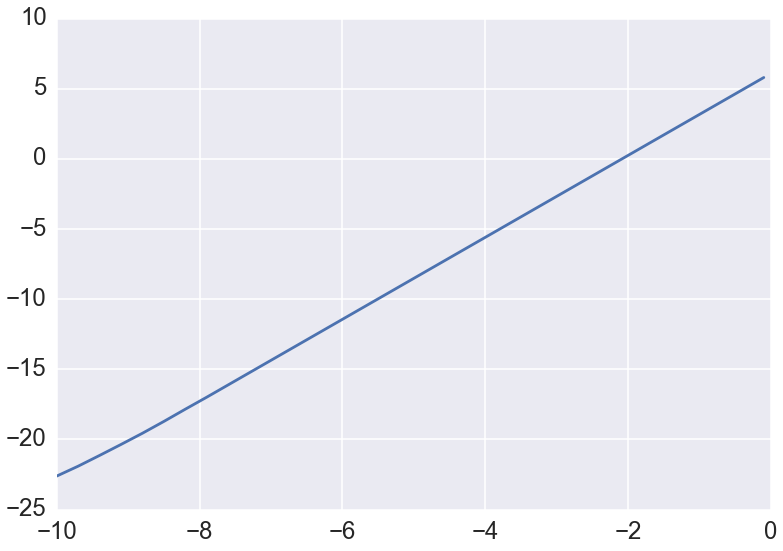

In [33]:
vel_summary = summary.groupby('V0').apply(lambda df: df.loc[df.snr == df.snr.max()]['peak_velocity']).reset_index()
plt.plot(vel_summary.V0, vel_summary.peak_velocity)
fcn = spline(vel_summary.V0, vel_summary.peak_velocity)
V0 = fcn.roots()[0]
print ('Best Reference Velocity = {:.2f} km/s'.format(V0))

In [ ]:
# Now, check various values of the mass-ratio q at this V0
reload(CombineCCFs)
drv = np.array([CombineCCFs.get_prim_rv(f) for f in original_files])
qvals2 = np.arange(0.18, 0.4, 0.0005)
snr2 = np.zeros(qvals2.size)
snr_err2 = np.zeros(qvals2.size)
height2 = np.zeros(qvals2.size)
height_err2 = np.zeros(qvals2.size)
stacked_ccfs = []
peak_velocity2 = np.zeros(qvals2.size)
peak_velocity_err2 = np.zeros(qvals2.size)
peak_width2 = np.zeros(qvals2.size )
peak_width_err2 = np.zeros(qvals2.size)
reference_velocity2 = np.zeros(qvals2.size)
f = 1.0   # Scale all error bars by this much

# Set up the lmfit model
def line(x, slope, intercept):
    return slope * x + intercept

def constant(x, constant):
    return x + constant

mod = lmfit.Model(line) + lmfit.Model(Gauss)
N=int(10/dV) # Number of indices to the left and right of the maximum to fit

if True:
    # Just in an if statement so the indentation is the same (easy copying)
    k = 0
    prim_vel = drv + V0
    for j, q in enumerate(qvals2):
        print(q)
        total_ccf = np.zeros(normed_ccfs.shape[1])
        minvel = np.inf
        #for i in range(30, normed_ccfs.shape[0]):
        for i in range(normed_ccfs.shape[0]):
            ccf = CombineCCFs.spline(xgrid, normed_ccfs[i])
            vel = prim_vel[i] * (1. - 1./q)
            if vel < minvel:
                minvel = vel
            total_ccf += ccf(xgrid + vel)
        good = np.where(xgrid > xgrid[0] - minvel)[0]
        stacked_ccfs.append(np.array((xgrid[good], total_ccf[good]/float(normed_ccfs.shape[0]))))

        # Fit the stacked CCF to a gaussian
        vel, corr = xgrid[good], total_ccf[good]/float(normed_ccfs.shape[0])
        maxidx = np.argmax(corr)
        result = mod.fit(corr[maxidx-N:maxidx+N], x=vel[maxidx-N:maxidx+N], 
                         amp=corr[maxidx], mu=vel[maxidx], sigma=4, slope=0, intercept=0)
        amp, mu, sig = result.params['amp'].value, result.params['mu'].value, result.params['sigma'].value
        slope, intercept = result.params['slope'].value, result.params['intercept'].value
        amp_err, mu_err, sig_err = result.params['amp'].stderr, result.params['mu'].stderr, result.params['sigma'].stderr
        slope_err, intercept_err = result.params['slope'].stderr, result.params['intercept'].stderr
        amp_err *= f
        mu_err *= f
        sig_err *= f
        slope_err *= f
        intercept_err *= f
        noise_idx = np.ones(vel.shape, dtype=bool)
        noise_idx[maxidx-N:maxidx+N] = 0
        noise = np.std(corr[noise_idx])
        baseline = np.mean(corr[noise_idx])

        height2[j] = ((amp + (intercept + slope*mu) - baseline))
        height_err2[j] = (np.sqrt(amp_err**2 + intercept_err**2 + (mu*slope_err)**2 + (slope*mu_err)**2))
        snr2[j] = (height2[j]/noise)
        snr_err2[j] = (height_err2[j]/noise)
        peak_velocity2[j] = (mu)
        peak_velocity_err2[j] = (mu_err)
        peak_width2[j] = (sig)
        peak_width_err2[j] = (sig_err)
        reference_velocity2[j] = V0

In [ ]:
# Make a plot of SNR vs detection significance
sns.set_style('white')
sns.set_style('ticks')
fig, ax = plt.subplots(1, 1)
#ax.plot(qvals2, snr2, lw=3, label='Peak Signal-To-Noise')
ax.plot(qvals2, height2, lw=3)
#ax.fill_between(qvals, snr-snr_err, snr+snr_err)
#ax.fill_between(qvals, height-height_err, height+height_err)
ax.set_xlabel('Mass ratio')
#ax.set_ylabel('Detection Significance')
ax.set_ylabel('Total CCF height')
print('Best q by snr = {:.2f}'.format(qvals2[np.argmax(snr2)]))
print('Best q by height = {:.2f}'.format(qvals2[np.argmax(height2)]))
plt.savefig('{}MassRatio_Estimation_Height.pdf'.format(output_dir))

In [ ]:
# make a plot if peak velocity width vs mass-ratio
fig, ax = plt.subplots(1, 1)
first = np.searchsorted(qvals2, 0.2)
first = 0
ax.plot(qvals2[first:], peak_width2[first:], lw=3)
ax.fill_between(qvals2[first:], (peak_width2-peak_width_err2)[first:], (peak_width2+peak_width_err2)[first:])

ax.set_xlabel('Mass ratio')
ax.set_ylabel('Width of CCF Peak')
ax.set_ylim((4, 6.5))
#ax.grid(True)

idx = np.argmin(np.array(peak_width2)[first:])
print('Minimum Peak width q = {}'.format(qvals2[idx+first]))

plt.savefig('{}Massratio_Estimation_Width.pdf'.format(output_dir))

In [ ]:
idx = np.argmin((qvals2 - 0.25)**2)
vel, corr = stacked_ccfs[idx]
plt.plot(vel, corr)
plt.xlabel("Velocity (km/s)")
plt.ylabel("CCF Power")

In [ ]:
# Plot both on the same axis
sns.set_style('white')
sns.set_style('ticks')
fig, ax = plt.subplots(1, 1)
#ax.plot(qvals2, snr2, lw=3, label='Peak Signal-To-Noise', color='blue')
ax.plot(qvals2, height2*1000, label='Peak CCF Height', color='blue')
ax.plot([], [], lw=3, label='Peak FWHM', color='green', ls='--')
ax.set_xlabel('Mass ratio')
#ax.set_ylabel('Detection Significance ($\sigma$)')
ax.set_ylabel('CCF Height x1000')
ax.grid(True)
leg = ax.legend(loc='best', fancybox=True)
ax2 = ax.twinx()
ax2.plot(qvals2, peak_width2*2.335, lw=3, color='green', ls='--')
ax2.set_ylabel('FWHM of CCF Peak (nm)')
ax.set_xlim((.18, .4))

plt.savefig('{}Massratio_Estimation_Both.pdf'.format(output_dir))



## Use the parameter uncertainties to make a likelihood function P(height|q)

In [ ]:

#fcn = spline(qvals2, snr2)
#err_fcn = spline(qvals2, snr_err2)
q = np.linspace(min(qvals2), max(qvals2), 2*qvals2.size)
fcn = spline(qvals2, height2)
err_fcn = spline(qvals2, height_err2)

def lnlike(h, q):
    return -0.5 * (h - fcn(q))**2/err_fcn(q)**2

def get_prob(h, q_values, tol=1e-8):
    probs = np.exp(lnlike(h, q_values))
    norm = np.sum(probs)
    P = probs/norm
    P[P < tol] = 0.0
    return P

In [ ]:
#P1 = get_prob(max(snr2), q)
P1 = get_prob(max(height2), q)
plt.plot(q, P1)
plt.xlim((.21, .28))
l, m, h = integral(q, P1, [.16, .5, .84], k=0)
print m, h-m, m-l

## Do the same thing for P(width | q)

In [ ]:
#first = np.searchsorted(qvals, 0.2)
first = 0
fcn = spline(qvals2[first:], peak_width2[first:])
err_fcn = spline(qvals2[first:], peak_width_err2[first:])

def lnlike(w, q):
    return -0.5 * (w - fcn(q))**2/err_fcn(q)**2

def get_prob(w, q_values, tol=1e-8):
    probs = np.exp(lnlike(w, q_values))
    norm = np.sum(probs)
    P = probs/norm
    P[P < tol] = 0.0
    return P

In [ ]:
w = min(peak_width[qvals2 > 0.2])
w = min(peak_width)
P2 = get_prob(w, q)
plt.plot(q, P2)
plt.xlim((.21, .28))
l, m, h = integral(q, P2, [.16, .5, .84], k=0)
print m, h-m, m-l

In [ ]:
P = P1 * P2
plt.plot(q, P1, label='Peak Height constraint', ls='-.', lw=3)
plt.plot(q, P2, label='Peak Width constraint', ls='--', lw=3)
plt.plot(q, P/P.sum(), label='Total constraint', ls='-', lw=3)
plt.xlabel('Mass Ratio')
plt.ylabel('Probability')
leg = plt.legend(loc='best', fancybox=True)
plt.xlim((.235, .26))
l, m, h = integral(q, P, [.16, .5, .84], k=0)
print m, h-m, m-l
plt.savefig('{}Massratio_Estimation_Total.pdf'.format(output_dir))